In [136]:
import os
import torch
import wandb
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets
from torchvision.transforms import transforms
import sys
from datetime import datetime
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random

from string import Template

### functions from _01_code/_99_common_utils/utils.py

In [137]:
def is_linux():
    if sys.platform.startswith("linux"):
        return True
    else:
        return False

def is_windows():
    if os.name == "nt":
        return True
    else:
        return False

def is_mac():
    if sys.platform == "darwin":
        return True
    else:
        return False

def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)

def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )

## [문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std값 찾기

### Train, Validation Dataset

In [138]:
# augment function
def augment_f_mnist_train(f_mnist_train):
    f_mnist_train_transforms = nn.Sequential(
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop([28, 28]),
        transforms.RandomCrop([28, 28]),
    )

    transformed_train_data = []

    for image, label in f_mnist_train:
        transformed_image = f_mnist_train_transforms(image)
        transformed_train_data.append((transformed_image, label))

    f_mnist_train = ConcatDataset([f_mnist_train, transformed_train_data])

    return f_mnist_train

def get_f_mnist_train_data():
    data_path = "." 

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    imgs = [img for img, _ in f_mnist_train]
    imgs = torch.concat(imgs, dim=0)
    mean = imgs.mean(dim=[0, 1, 2])
    std = imgs.std(dim=[0, 1, 2])

    ## augment ##
    f_mnist_train = augment_f_mnist_train(f_mnist_train)
    print(len(f_mnist_train))
    ##############

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=mean, std=std),
    )
    
    return train_data_loader, validation_data_loader, f_mnist_transforms, mean, std

### Test Dataset

In [139]:
def get_f_mnist_test_data(mean, std):
    data_path = "."
    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=mean, std=std),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

### GoogleNet(CNN) Model Class

In [140]:
def get_googlenet_model():
    class Inception(nn.Module):
        def __init__(self, c1, c2, c3, c4, **kwargs):
            super(Inception, self).__init__(**kwargs)
            self.b1_1 = nn.LazyConv2d(out_channels=c1, kernel_size=1)

            self.b2_1 = nn.LazyConv2d(out_channels=c2[0], kernel_size=1)
            self.b2_2 = nn.LazyConv2d(out_channels=c2[1], kernel_size=3, padding=1)

            self.b3_1 = nn.LazyConv2d(out_channels=c3[0], kernel_size=1)
            self.b3_2 = nn.LazyConv2d(out_channels=c3[1], kernel_size=5, padding=2)

            self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
            self.b4_2 = nn.LazyConv2d(out_channels=c4, kernel_size=1)

        def forward(self, x):
            b1 = torch.relu(self.b1_1(x))
            b2 = torch.relu(self.b2_2(torch.relu(self.b2_1(x))))
            b3 = torch.relu(self.b3_2(torch.relu(self.b3_1(x))))
            b4 = torch.relu(self.b4_2(self.b4_1(x)))
            return torch.cat((b1, b2, b3, b4), dim=1)
        
    class InceptionAux(nn.Module):
        def __init__(self, n_outputs, **kwargs):
            super(InceptionAux, self).__init__(**kwargs)

            self.conv = nn.Sequential(
                nn.LazyConv2d(out_channels=128, kernel_size=1),
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(out_features=1024),
                nn.ReLU(),
                nn.Dropout(),
                nn.LazyLinear(out_features=n_outputs),
            )
        
        def forward(self, x):
            x = self.conv(x)
            x = x.view(x.shape[0], -1)
            x = self.fc(x)
            return x
        
    class GoogleNet(nn.Module):
        def __init__(self, n_outputs=10):
            super(GoogleNet, self).__init__()
            self.conv_block = nn.Sequential(self.conv_blk_1(), self.conv_blk_2())
            self.inception_block_1 = self.inception_blk_1()
            self.inception_block_2 = self.inception_blk_2()
            self.inception_block_3 = self.inception_blk_3()
            self.aux_1 = InceptionAux(n_outputs)
            self.aux_2 = InceptionAux(n_outputs)

        def conv_blk_1(self):
            return nn.Sequential(
                nn.LazyConv2d(out_channels=64, kernel_size=7, stride=2, padding=3),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
        
        def conv_blk_2(self):
            return nn.Sequential(
                nn.LazyConv2d(out_channels=64, kernel_size=1),
                nn.ReLU(),
                nn.LazyConv2d(out_channels=192, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
        
        def inception_blk_1(self):
            return nn.Sequential(
                Inception(c1=64, c2=(96, 128), c3=(16, 32), c4=32),
                Inception(c1=128, c2=(128, 192), c3=(32, 96), c4=64),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                Inception(c1=192, c2=(96, 208), c3=(16, 48), c4=64),
            )
        
        def inception_blk_2(self):
            return nn.Sequential(
                Inception(c1=160, c2=(112, 224), c3=(24, 64), c4=64),
                Inception(c1=128, c2=(128, 256), c3=(24, 64), c4=64),
                Inception(c1=112, c2=(144, 288), c3=(32, 64), c4=64),
            )
        
        def inception_blk_3(self):
            return nn.Sequential(
                Inception(c1=256, c2=(160, 320), c3=(32, 128), c4=128),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                Inception(c1=256, c2=(160, 320), c3=(32, 128), c4=128),
                Inception(c1=384, c2=(192, 384), c3=(48, 128), c4=128),
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten()
            )
        
        def forward(self, x):
            x = self.conv_block(x)
            x = self.inception_block_1(x)
            aux_out_1 = self.aux_1(x)
            x = self.inception_block_2(x)
            aux_out_2 = self.aux_2(x)
            x = self.inception_block_3(x)
            return x, aux_out_1, aux_out_2

    my_model = GoogleNet()

    return my_model

### EarlyStopping

In [141]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss

### ClassificationTrainer

In [142]:
class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

### ClassificationTester

In [143]:
class ClassificationTester:
  def __init__(self, project_name, model, test_data_loader, transforms, checkpoint_file_path):
    self.project_name = project_name
    self.model = model
    self.test_data_loader = test_data_loader
    self.transforms = transforms

    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

    print("MODEL FILE: {0}".format(self.latest_file_path))

    self.model.load_state_dict(torch.load(self.latest_file_path, map_location=torch.device('cpu')))

  def test(self):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    num_corrects_test = 0
    num_tested_samples = 0

    with torch.no_grad():
      for test_batch in self.test_data_loader:
        input_test, target_test = test_batch

        input_test = self.transforms(input_test)

        output_test, _, _ = self.model(input_test)

        predicted_test = torch.argmax(output_test, dim=1)
        num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

        num_tested_samples += len(input_test)

      test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

  def test_single(self, input_test):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    with torch.no_grad():
      input_test = self.transforms(input_test)

      output_test, _, _ = self.model(input_test)
      predicted_test = torch.argmax(output_test, dim=1)

    return predicted_test.item()

### GoogleNetClassificationTrainer

In [144]:
class GoogLeNetClassificationTrainer(ClassificationTrainer):
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    super(GoogLeNetClassificationTrainer, self).__init__(
      project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
      run_time_str, wandb, device, checkpoint_file_path
    )

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      input_train = self.transforms(input_train)

      output_train, output_train_ax_1, output_train_ax_2 = self.model(input_train)
      loss = self.loss_fn(output_train, target_train)
      loss_aux_1 = self.loss_fn(output_train_ax_1, target_train)
      loss_aux_2 = self.loss_fn(output_train_ax_2, target_train)
      loss += 0.3 * (loss_aux_1 + loss_aux_2)

      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        input_validation = self.transforms(input_validation)

        output_validation, output_validation_ax_1, output_validation_ax_2 = self.model(input_validation)
        loss_validation = self.loss_fn(output_validation, target_validation)
        loss_validation_aux_1 = self.loss_fn(output_validation_ax_1, target_validation)
        loss_validation_aux_2 = self.loss_fn(output_validation_ax_2, target_validation)
        loss_validation += 0.3 * (loss_validation_aux_1 + loss_validation_aux_2)
        loss_validation += loss_validation.item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

### Do Train

In [145]:
def model_train(config):
    train_data_loader, validation_data_loader, f_mnist_transforms, mean, std = get_f_mnist_train_data()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = get_googlenet_model()
    # best_path = 'checkpoints/CSE533_Fashion_MNIST_checkpoint_2023-11-18_00-17-29.pt'
    # best_path = 'checkpoints/CSE533_Fashion_MNIST_checkpoint_2023-11-18_05-14-41.pt'
    # model.load_state_dict(torch.load(best_path, map_location=torch.device('cpu')))
    model.to(device)

    summary(
        model = model,
        input_size=(1, 1, 28, 28),
        col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"]
    )

    optimizer = optim.Adam(
        model.parameters(), 
        lr=wandb.config.learning_rate,
        weight_decay=config['weight_decay']
    )

    classification_trainer = GoogLeNetClassificationTrainer(
        config['project'], model, optimizer, train_data_loader, validation_data_loader, f_mnist_transforms,
        config['current_time_str'], wandb, device, config['checkpoints_path']
    )

    classification_trainer.train_loop()

    wandb.finish()

    return mean, std

### Do Test

In [156]:
def model_test(config, mean, std):
    f_mnist_test_images, test_data_loader, f_mnist_transforms = get_f_mnist_test_data(mean, std)

    test_model = get_googlenet_model()

    classification_tester = ClassificationTester(
        config['project'], test_model, test_data_loader, f_mnist_transforms, config['checkpoints_path']
    )
    classification_tester.test()

    # img, label = f_mnist_test_images[0]
    # print("     LABEL:", label)
    # plt.imshow(img)
    # plt.show()
    
    # output = classification_tester.test_single(
    #     torch.tensor(np.array(f_mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0)
    # )
    # print("PREDICTION:", output)

    while True:
        correct = 0
        wrong = 0
        correct_imgs = []
        wrong_imgs = []

        number = list([i for i in range(10_000)])
        select = random.sample(number, 10)
        for idx in select:
            output = classification_tester.test_single(
                torch.tensor(np.array(f_mnist_test_images[idx][0])).unsqueeze(dim=0).unsqueeze(dim=0)
            )
            label = f_mnist_test_images[idx][1]
            if label == output:
                correct += 1
                correct_imgs.append(f_mnist_test_images[idx])
            else:
                wrong += 1
                wrong_imgs.append(f_mnist_test_images[idx])

        if wrong > 0:
            for img in wrong_imgs:
                output = classification_tester.test_single(
                    torch.tensor(np.array(f_mnist_test_images[idx][0])).unsqueeze(dim=0).unsqueeze(dim=0)
                )
                print(f"Label : {f_mnist_test_images[idx][1]}, Output : {output}")
                ax = plt.figure().add_subplot()
                ax.imshow(f_mnist_test_images[idx][0])
                ax.set_xlabel(f"{f_mnist_test_images[idx][1]}, {output}")
            
            plt.show()

            print(f"Wrong : {wrong}, Correct : {correct}")
            break

    print(f"Mean: {mean}, Std: {std}")


### Main

In [147]:
config = {
    'epochs': 10_000,
    'batch_size': 2048,
    'validation_intervals': 10,
    'learning_rate': 0.001,
    'early_stop_patience': 5,
    'early_stop_delta': 0.00001,
    'weight_decay': 0.00001,
    'project': "CSE533_Fashion_MNIST",
    'use_wandb': True,
    'current_time_str': datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S'),
    'checkpoints_path': "checkpoints"
}

if not os.path.exists(config['checkpoints_path']):
    os.makedirs(config['checkpoints_path'])

wandb.init(
    mode="online" if config['use_wandb'] else "disabled",
    project=config['project'],
    notes="Homework3",
    tags=['googlenet', 'FashionMNIST'],
    name=config['current_time_str'],
    config=config
)

print(wandb.config)

mean = 0
std = 0

try:
    mean, std = model_train(config)
except:
    wandb.finish()

model_test(config, mean, std)

print("#### Q1 Answer ####")
print("Fashion Mnist Train Data's Mean\t:", mean)
print("Fashion Mnist Train Data's Std\t:", std)


{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 5, 'early_stop_delta': 1e-05, 'weight_decay': 1e-05, 'project': 'CSE533_Fashion_MNIST', 'use_wandb': True, 'current_time_str': '2023-11-18_23-33-09', 'checkpoints_path': 'checkpoints'}
110000


/home/nlp-06/anaconda3/envs/CSE533/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


[Epoch   1] T_loss: 5.45139, T_accuracy: 9.8282 | V_loss: 2.25833, V_accuracy: 9.7000 | Early stopping is stated! | T_time: 00:00:13, T_speed: 0.077
[Epoch  10] T_loss: 0.65521, T_accuracy: 84.9173 | V_loss: 0.44328, V_accuracy: 86.1000 | V_loss decreased (2.25833 --> 0.44328). Saving model... | T_time: 00:01:54, T_speed: 0.088
[Epoch  20] T_loss: 0.34840, T_accuracy: 92.2855 | V_loss: 0.34681, V_accuracy: 89.9600 | V_loss decreased (0.44328 --> 0.34681). Saving model... | T_time: 00:03:45, T_speed: 0.089
[Epoch  30] T_loss: 0.17930, T_accuracy: 96.0782 | V_loss: 0.50589, V_accuracy: 89.3400 | Early stopping counter: 1 out of 5 | T_time: 00:05:37, T_speed: 0.089
[Epoch  40] T_loss: 0.11321, T_accuracy: 97.5409 | V_loss: 0.54313, V_accuracy: 90.4400 | Early stopping counter: 2 out of 5 | T_time: 00:07:28, T_speed: 0.089
[Epoch  50] T_loss: 0.06609, T_accuracy: 98.5255 | V_loss: 0.66283, V_accuracy: 90.1000 | Early stopping counter: 3 out of 5 | T_time: 00:09:20, T_speed: 0.089
[Epoch  6

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch,▁▂▃▄▅▆▇█
Training accuracy (%),▁▇▇█████
Training loss,█▂▁▁▁▁▁▁
Training speed (epochs/sec.),▁▇██████
Validation accuracy (%),▁███████
Validation loss,█▁▁▂▂▂▂▂
Epoch,70
Training accuracy (%),99.32455
Training loss,0.03222
Training speed (epochs/sec.),0.0894
Validation accuracy (%),90.04


MODEL FILE: checkpoints/CSE533_Fashion_MNIST_checkpoint_latest.pt
TEST RESULTS: 89.310%


TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

/home/nlp-06/anaconda3/envs/CSE533/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


MODEL FILE: checkpoints/CSE533_Fashion_MNIST_checkpoint_latest.pt
TEST RESULTS: 89.310%
Label : 2, Output : 4


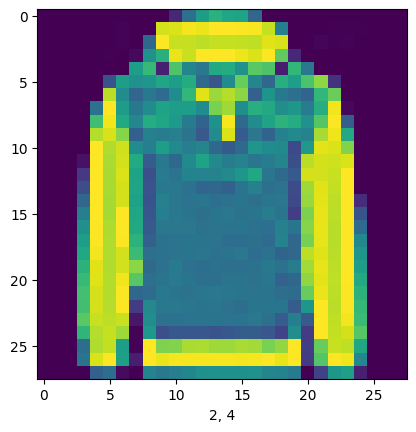

Wrong : 1, Correct : 9
Mean: 0.2862865924835205, Std: 0.35316306352615356


In [157]:
model_test(config, mean, std)

## 고찰
### 과제 1번
- 과제 1번은 Train Dataset이 매번 무작위로 정해지기 때문에 학습할 때 mean, std를 구하도록 해주었다.
- 그래서 매번 실행할때마다 결과값이 바뀌게 된다.

### 과제 2번
- vadlidation accuracy: 93.4800
- test accuracy: 90.3900
- 위와 같은 결과가 나와 과제 1, 과제 2 모두 해결했다.
- image augment를 사용해 학습 데이터를 추가해주었다.
- weight decay = 0, learning rate = 0.001 인 상태로 먼저 모델을 학습시켰는데, 이때 결과가 좋았다.
- 이때 Training loss가 0.02683이 나왔고, Validation loss가 0.6417이 나왔다.
- Training accuracy는 99.417이었고, Validation accuracy는 90.62였다.
- Training Dataset에 Overfitting되어 있다고 판단해 중간 checkpoint의 파라미터를 가져와 그 부분부터 학습시켰다.
- 그때의 weight decay는 0.001, learning rate = 2e-5였다.
- Training Dataset에 Overfitting되는 현상이 사라졌고, Validation accuracy도 증가하는 효과를 가져왔다.
- 처음 weight decay를 0.001로 적용했을 때, learning rate가 1e-3이었다.
- 학습을 시키니 첫 epoch 결과에서 계속 멤돌았다.
- weight decay를 적용하지 않고, learning rate만 적용하면 잘 학습되었다.
- 또한 weight decay를 0.001로 적용하고, learning rate를 2e-5로 설정해도 잘 학습되었다.
- 항상 모든 hyperparameter들은 적당한 값을 설정해야 한다는 것을 알게 되었다.
- 수업시간에 배운 내용을 직접 코딩해보고, 분석해보았다.
- 이론만 아는것보다 실습을 통해 직접 구현을 해보니 도움이 많이 된다는 것을 느꼈다.

### 과제 2번 추가
- 계속 Hyperparameters를 바꿔가며 실험을 해보았다.
- 많은 경우 Training Dataset에 Overfitting되어 validation accuracy는 낮아졌다.
- learning rate 0.001, weight decay 0.00001를 주었을 때 좋은 결과가 나와 최종 제출을 이것으로 했다.
    